# Software Review Project

In [39]:
## Loding the libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Load dataset

In [40]:
df = pd.read_csv(r"C:\Users\AMD\Documents\GitHub\Learning\SCMA-669\goodwilldata.csv")
df.head()

,Date,Retail Sales
period,,
1,Jan-92,19224
2,Feb-92,18162
3,Mar-92,23416
4,Apr-92,22381
5,May-92,22094


## Preprossing the data

In [41]:
df[['month','year']] = df['Date'].str.split('-',expand=True)
df.head()

,Date,Retail Sales,month,year
period,,,,
1,Jan-92,19224,Jan,92
2,Feb-92,18162,Feb,92
3,Mar-92,23416,Mar,92
4,Apr-92,22381,Apr,92
5,May-92,22094,May,92


In [42]:
pivot_table = pd.pivot_table(df, values='Retail Sales', index=['month'], columns=['year'], aggfunc=np.sum)
pivot_table

year,92,93,94,95,96
month,,,,,
Apr,22381.0,26315.0,41059.0,37026.0,46431.0
Aug,21456.0,26982.0,40778.0,37831.0,51141.0
Dec,25162.0,20439.0,38686.0,43244.0,NaN
Feb,18162.0,22874.0,28538.0,33194.0,39871.0
Jan,19224.0,26348.0,27841.0,35728.0,40796.0
Jul,19835.0,23479.0,38627.0,31031.0,47909.0
Jun,19589.0,21454.0,33751.0,33518.0,52344.0
Mar,23416.0,25245.0,34314.0,38872.0,47182.0
May,22094.0,25829.0,35321.0,35480.0,52404.0


In [43]:
pivot_table.mean(axis=1)

month
Apr    34642.40
Aug    35637.60
Dec    31882.75
Feb    28527.80
Jan    29987.40
Jul    32176.20
Jun    32131.20
Mar    33805.80
May    34225.60
Nov    34007.00
Oct    44002.60
Sep    37050.00
dtype: float64

In [44]:
pivot_table.mean(axis=1).sum()

408076.35

In [45]:
adj_factor = 12 / pivot_table.mean(axis=1).sum()
adj_factor

2.9406261842912488e-05

In [46]:
seasonl_adj = pivot_table.mean(axis=1) * adj_factor
seasonl_adj

month
Apr    1.018703
Aug    1.047969
Dec    0.937552
Feb    0.838896
Jan    0.881817
Jul    0.946182
Jun    0.944858
Mar    0.994102
May    1.006447
Nov    1.000019
Oct    1.293952
Sep    1.089502
dtype: float64

In [47]:
seasonl_adj = seasonl_adj.reindex(['Jan','Feb','Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
seasonl_adj

month
Jan    0.881817
Feb    0.838896
Mar    0.994102
Apr    1.018703
May    1.006447
Jun    0.944858
Jul    0.946182
Aug    1.047969
Sep    1.089502
Oct    1.293952
Nov    1.000019
Dec    0.937552
dtype: float64

In [48]:
seasonl_adj.sum()

12.000000000000002

In [49]:
np.ceil(len(df) / 12)

5.0

In [50]:
season = pd.concat([seasonl_adj]*5, ignore_index=True)[:len(df)]
season.index = df.index

In [51]:
df['seasonl_adj'] = season
df.head()

,Date,Retail Sales,month,year,seasonl_adj
period,,,,,
1,Jan-92,19224,Jan,92,0.881817
2,Feb-92,18162,Feb,92,0.838896
3,Mar-92,23416,Mar,92,0.994102
4,Apr-92,22381,Apr,92,1.018703
5,May-92,22094,May,92,1.006447


In [52]:
df['seasonl Sales'] = [i / j for i,j in zip(df['Retail Sales'], df['seasonl_adj'])]

In [53]:
df.head()

,Date,Retail Sales,month,year,seasonl_adj,seasonl Sales
period,,,,,,
1,Jan-92,19224,Jan,92,0.881817,21800.433272
2,Feb-92,18162,Feb,92,0.838896,21649.883823
3,Mar-92,23416,Mar,92,0.994102,23554.922064
4,Apr-92,22381,Apr,92,1.018703,21970.082879
5,May-92,22094,May,92,1.006447,21952.473385


In [54]:
new_df = df[['Date', 'seasonl Sales']]
new_df.index = pd.to_datetime(new_df['Date'])

In [55]:
del new_df['Date']
new_df.columns = ['sales']

In [74]:
model = ExponentialSmoothing(endog= new_df.sales).fit(smoothing_level =.9) # alpha

C:\Users\AMD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [75]:
prediction = model.forecast(steps= 12)
prediction

1996-11-01    48928.359067
1996-12-01    48928.359067
1997-01-01    48928.359067
1997-02-01    48928.359067
1997-03-01    48928.359067
1997-04-01    48928.359067
1997-05-01    48928.359067
1997-06-01    48928.359067
1997-07-01    48928.359067
1997-08-01    48928.359067
1997-09-01    48928.359067
1997-10-01    48928.359067
Freq: MS, dtype: float64

In [76]:
prediction.values * df.iloc[10:10+12,4].values

array([48929.27630193, 45872.90510823, 43145.87526617, 41045.80258436,
       48639.78971412, 49843.48990979, 49243.79801216, 46230.37500258,
       46295.1210088 , 51275.38380739, 53307.54512267, 63310.94696396])

In [77]:
new_prediction = pd.Series(prediction.values * df.iloc[10:10+12,4].values, index=prediction.index)

<Axes: xlabel='Date'>

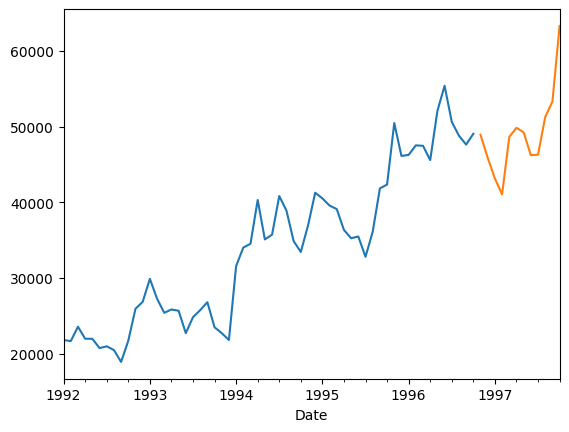

In [78]:
new_df.sales.plot()
new_prediction.plot()

In [79]:
# forecast
pd.DataFrame(new_prediction, columns=['forecast'])

,forecast
1996-11-01,48929.276302
1996-12-01,45872.905108
1997-01-01,43145.875266
1997-02-01,41045.802584
1997-03-01,48639.789714
1997-04-01,49843.489910
1997-05-01,49243.798012
1997-06-01,46230.375003
1997-07-01,46295.121009
1997-08-01,51275.383807
